In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import numpy as np
import pandas as pd
import torch
import torch as th
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

/tmp/ipykernel_2728945/2612853015.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [54]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary, extract_last_K_step_avg_summary
from posthoc_analysis_utils import sweep_collect_eval_data, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_indiv_rule_dynam, extract_and_convert, visualize_train_heldout_rule
from circuit_toolkit.plot_utils import saveallforms
from stats_plot_utils import estimate_CI

### Set Paths

In [5]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
# figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/SiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [6]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SiTfigdir = join(figroot, "SiT_raven")
SSMfigdir = join(figroot, "SSM_raven")
synopsisdir = join(figroot, "Figure_model_synopsis")

In [7]:
!mkdir {synopsisdir}

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_model_synopsis’: File exists


In [9]:
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [10]:
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven
!mkdir  /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven

mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/GPT2_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/EDM_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/DiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SiT_raven’: File exists
mkdir: cannot create directory ‘/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/SSM_raven’: File exists


## EDM

In [11]:
tb_data_col_EDM = extract_all_runs(EDM_exproot)

Extracted data from BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0105/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_48M_RAVEN10_abstract_20240705-1908/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2314/tensorboard_logs
Extracted data from WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs
Extracted data from BigBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1903/tensorboard_logs
Extracted data from BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Extracted data from BigBlnrX3_new_stream16M_RAVEN10_abstract_20240705-0237/tensorboard_logs
Extracted d

In [12]:
for key in tb_data_col_EDM.keys():
    if tb_data_col_EDM[key]["step"].max() < 999999:
        print(key)
        print(tb_data_col_EDM[key]["step"].max(), "steps, unfinished")

BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
75200 steps, unfinished
WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
67500 steps, unfinished
BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
79200 steps, unfinished
WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs
873100 steps, unfinished


In [13]:
def simplify_runname_EDM(run_name):
    return run_name.replace("/tensorboard_logs", "").split("_2024")[0].replace("_RAVEN10_abstract", "")#.replace("_new", "")

syndf_EDM = extract_last_step_summary(tb_data_col_EDM, simplify_runname_EDM, exclude_runs=())
syndf_EDM

tag,Learning Rate,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,full_name,step,step/epoch
run_name,,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.0002,0.676221,0.644018,0.638509,3923.0,0.239258,490.0,0.221191,453.0,BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs,999999,999999
WideBlnrX3_new_stream0_016M,0.0002,0.472555,0.344257,0.547038,3361.0,0.139160,285.0,0.022461,46.0,WideBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0105/tensorboard_logs,999999,999999
WideBlnrX3_new_stream0_16M_heldout0,0.0002,0.643560,0.593999,0.710286,4364.0,0.214355,439.0,0.446777,915.0,WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs,999999,999999
WideBlnrX3_new_stream0_48M,0.0002,0.638694,0.590333,0.739746,4545.0,0.169922,348.0,0.535645,1097.0,WideBlnrX3_new_stream0_48M_RAVEN10_abstract_20240705-1908/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_48M_heldout0,0.0002,0.636146,0.614749,0.749023,4602.0,0.129395,265.0,0.600098,1229.0,BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2314/tensorboard_logs,999999,999999
WideBlnrX3_new_stream0_016M_heldout0,0.0002,0.459644,0.410992,0.546712,3359.0,0.134277,275.0,0.018066,37.0,WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_48M_heldout0,0.0002,0.636382,0.616904,0.749512,4605.0,0.145508,298.0,0.596191,1221.0,BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,999999,999999
BigBlnrX3_new_stream1_6M,0.0002,0.629097,0.633882,0.745605,4581.0,0.142090,291.0,0.589355,1207.0,BigBlnrX3_new_stream1_6M_RAVEN10_abstract_20240705-1903/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.708024,0.662795,0.651204,4001.0,0.277832,569.0,0.219238,449.0,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs,75200,75000


In [14]:
syndf_EDM.index[syndf_EDM.index.duplicated()]

Index(['BigBlnrX3_new_stream0_48M_heldout0',
       'WideBlnrX3_new_stream4_8M_heldout0',
       'BigBlnrX3_new_stream0_48M_heldout0',
       'BigBlnrX3_new_stream0_16M_heldout0',
       'BigBlnrX3_new_stream0_16M_heldout0', 'WideBlnrX3_new_stream4_8M',
       'WideBlnrX3_new_stream4_8M_heldout0'],
      dtype='object', name='run_name')

In [15]:
def simplify_runname_EDM(run_name):
    return run_name.replace("/tensorboard_logs", "").split("_2024")[0].replace("_RAVEN10_abstract", "")#.replace("_new", "")

excluded_runs = [
    "BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 75200
    "WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs", # 67500
    "BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 79200
    "WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs", # 873100 
    # "WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs",
    ] # 873100

syndf_EDM = extract_last_step_summary(tb_data_col_EDM, simplify_runname_EDM, exclude_runs=excluded_runs)
# sort index 
syndf_EDM = syndf_EDM.sort_index()
syndf_EDM

Excluding BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Excluding WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
Excluding BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Excluding WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs


tag,Learning Rate,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,full_name,step,step/epoch
run_name,,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.0002,0.676221,0.644018,0.638509,3923.0,0.239258,490.0,0.221191,453.0,BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs,999999,999999
BaseBlnrX3_new_stream0_16M_heldout0,0.0002,0.683712,0.643912,0.655762,4029.0,0.249512,511.0,0.254395,521.0,BaseBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240921-2218/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_016M,0.0002,0.348312,0.312391,0.555827,3415.0,0.147949,303.0,0.053223,109.0,BigBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0104/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_016M_heldout0,0.0002,0.330067,0.218826,0.577474,3548.0,0.168457,345.0,0.084473,173.0,BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_16M,0.0002,0.620162,0.568654,0.718424,4414.0,0.231934,475.0,0.455078,932.0,BigBlnrX3_new_stream0_16M_RAVEN10_abstract_20240828-1332/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.625357,0.557646,0.700684,4305.0,0.240234,492.0,0.405273,830.0,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.624024,0.550257,0.700521,4304.0,0.240234,492.0,0.404785,829.0,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_48M,0.0002,0.628544,0.652743,0.739095,4541.0,0.145508,298.0,0.582031,1192.0,BigBlnrX3_new_stream0_48M_RAVEN10_abstract_20240828-1332/tensorboard_logs,999999,999999
BigBlnrX3_new_stream0_48M_heldout0,0.0002,0.636382,0.616904,0.749512,4605.0,0.145508,298.0,0.596191,1221.0,BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,999999,999999


In [16]:
syndf_EDM.to_csv(join(tabdir, "EDM_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_EDM, open(join(tabdir, "EDM_raven_tensorboard_raw_data.pkl"), "wb"))

#### Compute the most stable last 10 epoch average

In [17]:
excluded_runs = [
    "BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 75200
    "WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs", # 67500
    "BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs", # 79200
    "WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs", # 873100 
    # "WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs",
    ] # 873100

syndf_EDM_std = extract_last_K_step_avg_summary(tb_data_col_EDM, simplify_runname_EDM, exclude_runs=excluded_runs, K=10, compute_std=True)
syndf_EDM_std = syndf_EDM_std.sort_index()
syndf_EDM_std.to_csv(join(tabdir, "EDM_raven_tensorboard_data_last10.csv"))
syndf_EDM_std

Excluding BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Excluding WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs
Excluding BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2052/tensorboard_logs
Excluding WideBlnrX3_new_stream4_8M_RAVEN10_abstract_20240705-1908/tensorboard_logs


,Learning Rate,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,full_name,...,step/epoch,Learning Rate_std,Loss/average_std,Loss/batch_std,Rules/anyvalid_std,Rules/anyvalid_cnt_std,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std
run_name,,,,,,,,,,,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.0002,0.676231,0.657270,0.641960,3944.2,0.234912,481.1,0.232520,476.2,BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs,...,977500,0.0,0.000007,0.044140,0.008417,51.712453,0.008449,17.304142,0.009209,18.860894
BaseBlnrX3_new_stream0_16M_heldout0,0.0002,0.683721,0.663645,0.647087,3975.7,0.233838,478.9,0.259082,530.6,BaseBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240921-2218/tensorboard_logs,...,977500,0.0,0.000007,0.058862,0.007054,43.338589,0.012916,26.451003,0.012321,25.233135
BigBlnrX3_new_stream0_016M,0.0002,0.348348,0.250462,0.556755,3420.7,0.147754,302.6,0.054883,112.4,BigBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0104/tensorboard_logs,...,977500,0.0,0.000024,0.061234,0.003219,19.776810,0.008132,16.654662,0.005535,11.335294
BigBlnrX3_new_stream0_016M_heldout0,0.0002,0.330103,0.237693,0.565934,3477.1,0.152783,312.9,0.079687,163.2,BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs,...,977500,0.0,0.000024,0.048325,0.007819,48.038064,0.007471,15.300327,0.005303,10.860735
BigBlnrX3_new_stream0_16M,0.0002,0.620175,0.557252,0.722949,4441.8,0.222705,456.1,0.458154,938.3,BigBlnrX3_new_stream0_16M_RAVEN10_abstract_20240828-1332/tensorboard_logs,...,977500,0.0,0.000009,0.065364,0.006535,40.151934,0.010866,22.253339,0.011154,22.842699
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.625371,0.577405,0.704215,4326.7,0.237646,486.7,0.409961,839.6,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs,...,977500,0.0,0.000010,0.056657,0.007770,47.740153,0.005949,12.184234,0.008458,17.321791
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.624039,0.574351,0.699447,4297.4,0.241748,495.1,0.408447,836.5,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,...,977500,0.0,0.000010,0.057644,0.009656,59.328090,0.006775,13.876038,0.014232,29.148089
BigBlnrX3_new_stream0_48M,0.0002,0.628549,0.588036,0.742480,4561.8,0.149902,307.0,0.582324,1192.6,BigBlnrX3_new_stream0_48M_RAVEN10_abstract_20240828-1332/tensorboard_logs,...,977500,0.0,0.000004,0.062683,0.006445,39.600224,0.005629,11.527744,0.006608,13.533498
BigBlnrX3_new_stream0_48M_heldout0,0.0002,0.636387,0.595781,0.730111,4485.8,0.133887,274.2,0.581250,1190.4,BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,...,977500,0.0,0.000004,0.031827,0.009327,57.303868,0.007172,14.687863,0.009563,19.585709


### Overall scaling curve

In [18]:
syndf_EDM = pd.read_csv(join(tabdir, "EDM_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col_EDM = pkl.load(open(join(tabdir, "EDM_raven_tensorboard_raw_data.pkl"), "rb"))

In [19]:
syndf_EDM["heldout"] = syndf_EDM.index.map(lambda x: "_heldout0" in x)
syndf_EDM["scale"] = syndf_EDM.index.map(lambda x: "EDMx3" if "BigBlnrX3" in x else "EDMx2" if "WideBlnrX3" in x else "EDMx1" if "BaseBlnrX3" in x else None)
syndf_EDM["dataset_size"] = syndf_EDM.index.map(extract_and_convert)
syndf_EDM["Rules/c23"] = syndf_EDM["Rules/c2"] + syndf_EDM["Rules/c3"]
syndf_EDM["Rules/c23_cnt"] = syndf_EDM["Rules/c2_cnt"] + syndf_EDM["Rules/c3_cnt"]

In [20]:
syndf_EDM_sorted = syndf_EDM.sort_values(by=["heldout", "scale", "dataset_size"], ascending=[False, True, True])
syndf_EDM_sorted

,Learning Rate,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,full_name,...,Rules/anyvalid_cnt_std,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std,heldout,scale,dataset_size,Rules/c23,Rules/c23_cnt
run_name,,,,,,,,,,,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M_heldout0,0.0002,0.683721,0.663645,0.647087,3975.7,0.233838,478.9,0.259082,530.6,BaseBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240921-2218/tensorboard_logs,...,43.338589,0.012916,26.451003,0.012321,25.233135,True,EDMx1,0.160,0.492920,1009.5
WideBlnrX3_new_stream0_016M_heldout0,0.0002,0.459676,0.402344,0.540527,3321.0,0.132568,271.5,0.019482,39.9,WideBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0105/tensorboard_logs,...,50.044425,0.005851,11.983785,0.003307,6.773314,True,EDMx2,0.016,0.152051,311.4
WideBlnrX3_new_stream0_16M_heldout0,0.0002,0.643569,0.622704,0.714290,4388.6,0.217773,446.0,0.445654,912.7,WideBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs,...,35.160584,0.010737,21.989897,0.012312,25.214855,True,EDMx2,0.160,0.663428,1358.7
WideBlnrX3_new_stream0_48M_heldout0,0.0002,0.646993,0.639558,0.729134,4479.8,0.157861,323.3,0.534131,1093.9,WideBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs,...,83.110101,0.011262,23.065366,0.019573,40.084494,True,EDMx2,0.480,0.691992,1417.2
WideBlnrX3_new_stream1_6M_heldout0,0.0002,0.647321,0.636337,0.726449,4463.3,0.158740,325.1,0.532373,1090.3,WideBlnrX3_new_stream1_6M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs,...,78.812083,0.010153,20.792360,0.011295,23.132709,True,EDMx2,1.600,0.691113,1415.4
WideBlnrX3_new_stream4_8M_heldout0,0.0002,0.646801,0.637583,0.725391,4456.8,0.164111,336.1,0.524463,1074.1,WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,...,45.467449,0.004725,9.677580,0.014117,28.911551,True,EDMx2,4.800,0.688574,1410.2
WideBlnrX3_new_stream4_8M_heldout0,0.0002,0.647646,0.637003,0.727148,4467.6,0.153906,315.2,0.536426,1098.6,WideBlnrX3_new_stream4_8M_heldout0_RAVEN10_abstract_20240708-2207/tensorboard_logs,...,47.528237,0.007419,15.193566,0.011516,23.585306,True,EDMx2,4.800,0.690332,1413.8
WideBlnrX3_new_stream16M_heldout0,0.0002,0.647784,0.650063,0.723617,4445.9,0.153760,314.9,0.536035,1097.8,WideBlnrX3_new_stream16M_heldout0_RAVEN10_abstract_20240708-2054/tensorboard_logs,...,36.930716,0.010092,20.669086,0.010830,22.180071,True,EDMx2,16.000,0.689795,1412.7
BigBlnrX3_new_stream0_016M_heldout0,0.0002,0.330103,0.237693,0.565934,3477.1,0.152783,312.9,0.079687,163.2,BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs,...,48.038064,0.007471,15.300327,0.005303,10.860735,True,EDMx3,0.016,0.232471,476.1


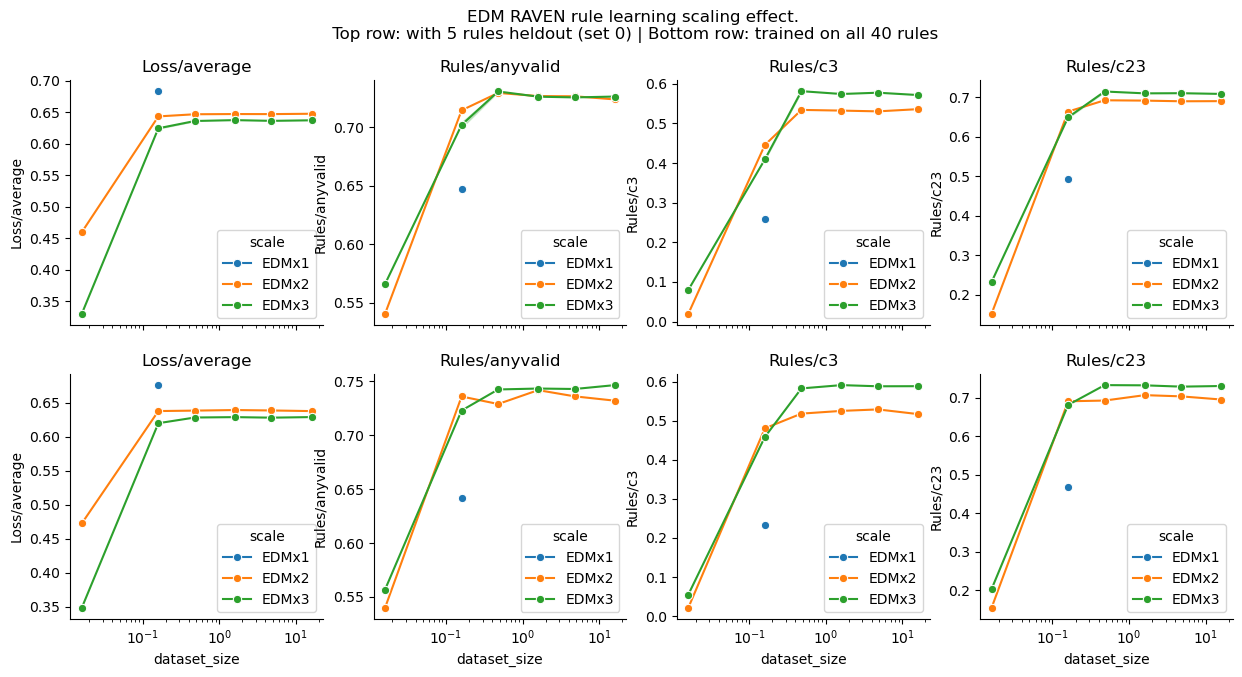

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for ax, metric in zip(axs[0,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_EDM_sorted[syndf_EDM_sorted.heldout==True], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["EDMx1", "EDMx2", "EDMx3"])
    ax.set_title(metric)
    ax.set_xscale('log')
for ax, metric in zip(axs[1,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_EDM_sorted[syndf_EDM_sorted.heldout==False], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["EDMx1", "EDMx2", "EDMx3"])
    ax.set_title(metric)
    ax.set_xscale('log')
plt.suptitle("EDM RAVEN rule learning scaling effect.\n Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "EDM_raven_rule_learning_scaling_effect_EDMx1", fig)
plt.show()

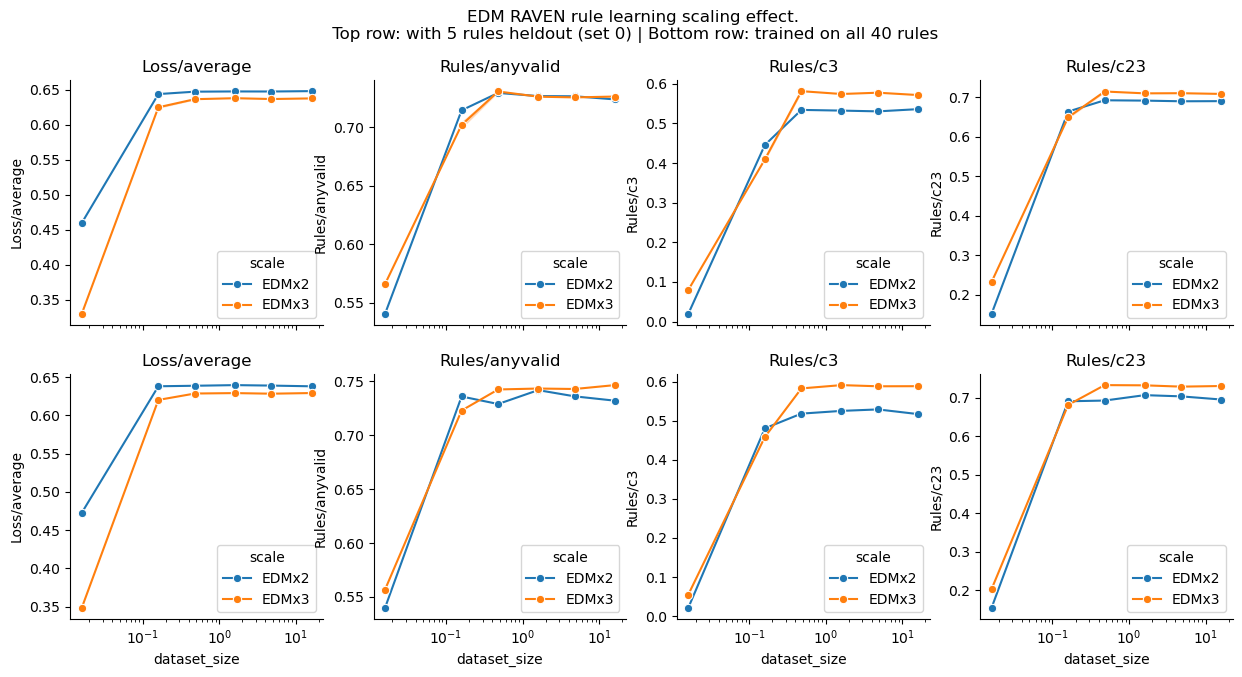

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for ax, metric in zip(axs[0,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_EDM_sorted[syndf_EDM_sorted.heldout==True], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["EDMx2", "EDMx3"])
    ax.set_title(metric)
    ax.set_xscale('log')
for ax, metric in zip(axs[1,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_EDM_sorted[syndf_EDM_sorted.heldout==False], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["EDMx2", "EDMx3"])
    ax.set_title(metric)
    ax.set_xscale('log')
plt.suptitle("EDM RAVEN rule learning scaling effect.\n Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "EDM_raven_rule_learning_scaling_effect", fig)
plt.show()

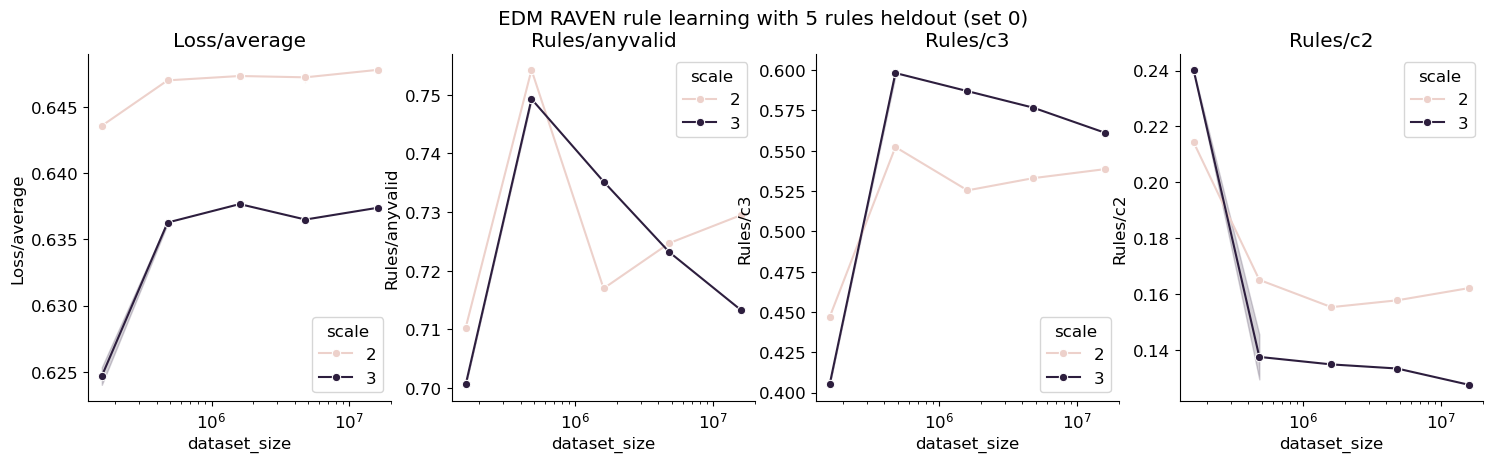

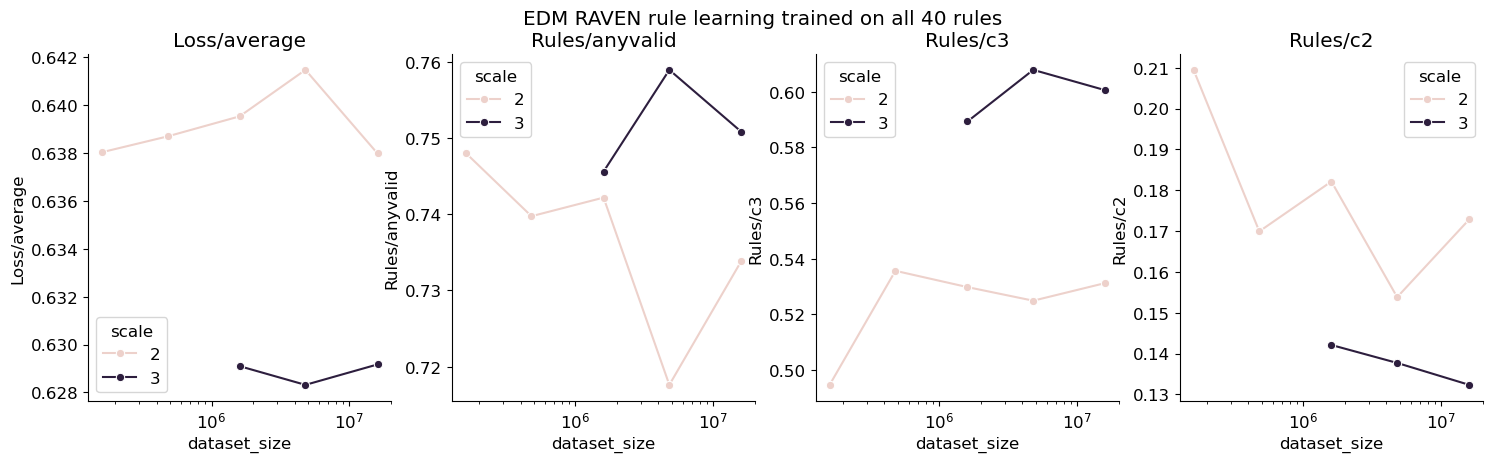

In [58]:
figh, axs = plt.subplots(1, 4, figsize=(18, 4.5), sharex=True, squeeze=False)
for ax, metric in zip(axs[0, :], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==True], x="dataset_size", y=metric, 
                    hue="scale", ax=ax, marker='o', )
    ax.set_title(metric)
    plt.xscale('log')
plt.suptitle("EDM RAVEN rule learning with 5 rules heldout (set 0)")
plt.show()

figh, axs = plt.subplots(1, 4, figsize=(18, 4.5), sharex=True, squeeze=False)
for ax, metric in zip(axs[0, :], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c2",]):
    sns.lineplot(data=syndf_EDM[syndf_EDM.heldout==False], x="dataset_size", y=metric, 
                    hue="scale", ax=ax, marker='o', )
    ax.set_title(metric)
    plt.xscale('log')
plt.suptitle("EDM RAVEN rule learning trained on all 40 rules")
plt.show()

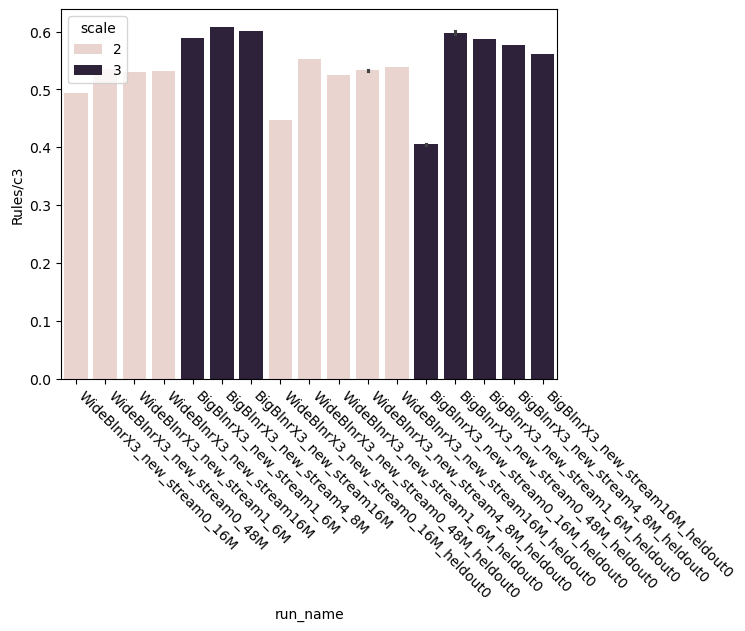

In [68]:
syndf_EDM_sorted = syndf_EDM.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, True, True])
sns.barplot(data=syndf_EDM_sorted, x="run_name", y="Rules/c3", hue="scale")
plt.xticks(rotation=-45, ha='left')
plt.show()

### General learning dynamics

In [28]:
# exclude columns with std in the name
syndf_EDM[syndf_EDM.columns[~syndf_EDM.columns.str.contains("std")]]

,Learning Rate,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,full_name,step,step/epoch,heldout,scale,dataset_size,Rules/c23,Rules/c23_cnt
run_name,,,,,,,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.0002,0.676231,0.657270,0.641960,3944.2,0.234912,481.1,0.232520,476.2,BaseBlnrX3_new_stream0_16M_RAVEN10_abstract_20240921-2218/tensorboard_logs,999999,977500,False,EDMx1,0.160,0.467432,957.3
BaseBlnrX3_new_stream0_16M_heldout0,0.0002,0.683721,0.663645,0.647087,3975.7,0.233838,478.9,0.259082,530.6,BaseBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240921-2218/tensorboard_logs,999999,977500,True,EDMx1,0.160,0.492920,1009.5
BigBlnrX3_new_stream0_016M,0.0002,0.348348,0.250462,0.556755,3420.7,0.147754,302.6,0.054883,112.4,BigBlnrX3_new_stream0_016M_RAVEN10_abstract_20240816-0104/tensorboard_logs,999999,977500,False,EDMx3,0.016,0.202637,415.0
BigBlnrX3_new_stream0_016M_heldout0,0.0002,0.330103,0.237693,0.565934,3477.1,0.152783,312.9,0.079687,163.2,BigBlnrX3_new_stream0_016M_heldout0_RAVEN10_abstract_20240816-0104/tensorboard_logs,999999,977500,True,EDMx3,0.016,0.232471,476.1
BigBlnrX3_new_stream0_16M,0.0002,0.620175,0.557252,0.722949,4441.8,0.222705,456.1,0.458154,938.3,BigBlnrX3_new_stream0_16M_RAVEN10_abstract_20240828-1332/tensorboard_logs,999999,977500,False,EDMx3,0.160,0.680859,1394.4
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.625371,0.577405,0.704215,4326.7,0.237646,486.7,0.409961,839.6,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240708-2308/tensorboard_logs,999999,977500,True,EDMx3,0.160,0.647607,1326.3
BigBlnrX3_new_stream0_16M_heldout0,0.0002,0.624039,0.574351,0.699447,4297.4,0.241748,495.1,0.408447,836.5,BigBlnrX3_new_stream0_16M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,999999,977500,True,EDMx3,0.160,0.650195,1331.6
BigBlnrX3_new_stream0_48M,0.0002,0.628549,0.588036,0.742480,4561.8,0.149902,307.0,0.582324,1192.6,BigBlnrX3_new_stream0_48M_RAVEN10_abstract_20240828-1332/tensorboard_logs,999999,977500,False,EDMx3,0.480,0.732227,1499.6
BigBlnrX3_new_stream0_48M_heldout0,0.0002,0.636387,0.595781,0.730111,4485.8,0.133887,274.2,0.581250,1190.4,BigBlnrX3_new_stream0_48M_heldout0_RAVEN10_abstract_20240709-1249/tensorboard_logs,999999,977500,True,EDMx3,0.480,0.715137,1464.6


In [63]:
for expfullname in syndf_EDM.full_name:
    tb_record = tb_data_col_EDM[expfullname]
    expname = expfullname.split("/")[0]
    print(expfullname)
    # print(tb_record.keys())
    # print(tb_record['tag'].unique())    
    tb_anyvalid = tb_record[tb_record.tag=='Val/AnyValid']
    tb_anyvalid["anyvalid_renorm"] = (tb_anyvalid["value"] - 2/3) * 3
    figh = plt.figure(figsize=(6, 5))
    sns.lineplot(data=tb_anyvalid, x='step', y='anyvalid_renorm', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3'], x='step', y='value', label='C3')
    # sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid'], x='step', y='value', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/anyvalid'], x='step', y='value', label='AnyValid_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/c3'], x='step', y='value', label='C3_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/c2'], x='step', y='value', label='C2_abinit')
    plt.legend() # ['Val/C3', 'Val/C3_abinit', 'Val/C2_abinit', 'Val/AnyValid_abinit']
    plt.title(expname)
    saveallforms(EDMfigdir, f"{expname}_valid_consist_summary", figh)
    plt.show()
    # raise ValueError

### Individual rule learning dynamics

In [26]:
epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
eval_sample_num = rule_list_all.shape[1]


diffusion model, just fetch ab init generation
(401, 2048, 3) (401, 2, 2048)


In [ ]:
for expfullname in syndf_EDM.full_name:
    tb_record = tb_data_col_EDM[expfullname]
    expname = expfullname.split("/tensorboard_logs")[0]
    prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, EDM_exproot, prefix=prefix)
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
    eval_sample_num = rule_list_all.shape[1]
    print(expname)
    if "heldout0" in expname:
        heldout_id = [1, 16, 20, 34, 37]  
    else:
        heldout_id = []

    figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                            titlestr=f"{expname}\nValid rule count separated by rule type")
    saveallforms(EDMfigdir, f"{expname}_indiv_rule_validity", figh)

    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
    saveallforms(EDMfigdir, f"{expname}_indiv_rule_consistency", figh)
    
    figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num * 3, reflevel=1 / 40,
                                titlestr=f"{expname}\nValid rule fraction")
    saveallforms(EDMfigdir, f"{expname}_train_held_rule_validity", figh)

    figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num, reflevel=1 / 40,
                                titlestr=f"{expname}\nC3 sample fraction")
    saveallforms(EDMfigdir, f"{expname}_train_held_rule_consistency", figh)

## DiT

In [30]:
tb_data_col_DiT = extract_all_runs(DiT_exproot)

Extracted data from 096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205/tensorboard_logs
Extracted data from 091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs
Extracted data from 085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs
Extracted data from 099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
Extracted data from 102-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240921-1651/tensorboard_logs
Extracted data from 087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs
Extracted data from 090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs
Extracted data from 095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205/tensorboard_logs
Extracted data from 086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs
Extracted data from 101-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240921-1650/tens

In [32]:
for key in sorted(tb_data_col_DiT.keys()):
    if tb_data_col_DiT[key]["step"].max() < 999999:
        print(key)
        print(tb_data_col_DiT[key]["step"].max(), "steps, unfinished run")

099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
841900 steps, unfinished run
100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs
819800 steps, unfinished run


In [33]:
excluded_runs = [
    "099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs", #841900 steps, unfinished run
    "100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs", #819800 steps, unfinished run
]
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_DiT = extract_last_step_summary(tb_data_col_DiT, simplify_runname, excluded_runs)
syndf_DiT = syndf_DiT.sort_index()
syndf_DiT

Excluding 099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
Excluding 100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs


tag,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,step,step/epoch
run_name,,,,,,,,,,,,
085-uncond-DiT_S_1-stream0_16M,0.094453,0.089580,0.737956,4534.0,0.111816,229.0,0.595703,1220.0,18.965296,085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs,1000000,1000000
086-uncond-DiT_S_1-stream1_6M,0.094237,0.098248,0.792806,4871.0,0.117676,241.0,0.650391,1332.0,18.855453,086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs,1000000,1000000
087-uncond-DiT_S_1-stream16M,0.094620,0.098189,0.780762,4797.0,0.122559,251.0,0.633789,1298.0,16.748566,087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs,1000000,1000000
088-uncond-DiT_S_1-stream16M_heldout0,0.095244,0.096979,0.778483,4783.0,0.120117,246.0,0.636230,1303.0,19.278015,088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs,1000000,1000000
089-uncond-DiT_S_1-stream1_6M_heldout0,0.096174,0.095929,0.765462,4703.0,0.125977,258.0,0.608398,1246.0,19.268356,089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs,1000000,1000000
090-uncond-DiT_S_1-stream0_16M_heldout0,0.095534,0.094757,0.734701,4514.0,0.142090,291.0,0.571289,1170.0,18.949669,090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs,1000000,1000000
091-uncond-DiT_B_1-stream16M,0.093849,0.094762,0.754069,4633.0,0.125000,256.0,0.603027,1235.0,8.272856,091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs,1000000,1000000
092-uncond-DiT_B_1-stream1_6M,0.094446,0.092289,0.771810,4742.0,0.107422,220.0,0.643066,1317.0,8.720461,092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs,1000000,1000000
093-uncond-DiT_B_1-stream1_6M_heldout0,0.095623,0.098117,0.798991,4909.0,0.138672,284.0,0.651855,1335.0,8.789845,093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs,1000000,1000000


In [35]:
syndf_DiT.to_csv(join(tabdir, "DiT_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_DiT, open(join(tabdir, "DiT_raven_tensorboard_raw_data.pkl"), "wb"))

In [37]:
excluded_runs = [
    "099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs", #841900 steps, unfinished run
    "100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs", #819800 steps, unfinished run
]
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_DiT_std = extract_last_K_step_avg_summary(tb_data_col_DiT, simplify_runname, exclude_runs=excluded_runs, K=10, compute_std=True)
syndf_DiT_std = syndf_DiT_std.sort_index()
syndf_DiT_std.to_csv(join(tabdir, "DiT_raven_tensorboard_data_last10.csv"))
syndf_DiT_std

Excluding 099-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_20240816-0053/tensorboard_logs
Excluding 100-RAVEN10_abstract-uncond-DiT_B_1-stream0_016M_heldout0_20240816-0053/tensorboard_logs


,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,...,step/epoch,Loss/average_std,Loss/batch_std,Rules/anyvalid_std,Rules/anyvalid_cnt_std,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std,Speed/steps_per_sec_std
run_name,,,,,,,,,,,,,,,,,,,,,
085-uncond-DiT_S_1-stream0_16M,0.094250,0.093119,0.753874,4631.8,0.122949,251.8,0.602930,1234.8,18.911798,085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs,...,977500,0.000787,0.007092,0.023433,143.975152,0.010715,21.943361,0.026732,54.747501,0.520298
086-uncond-DiT_S_1-stream1_6M,0.094534,0.094586,0.767692,4716.7,0.135107,276.7,0.613086,1255.6,19.068166,086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs,...,977500,0.000738,0.005965,0.027885,171.326232,0.011065,22.662009,0.038581,79.013642,0.074948
087-uncond-DiT_S_1-stream16M,0.094520,0.095650,0.782910,4810.2,0.130811,267.9,0.631982,1294.3,18.946301,087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs,...,977500,0.000667,0.004046,0.015262,93.768983,0.008754,17.928562,0.015125,30.976873,0.775090
088-uncond-DiT_S_1-stream16M_heldout0,0.095964,0.096755,0.768522,4721.8,0.125732,257.5,0.619727,1269.2,19.285516,088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs,...,977500,0.000607,0.005439,0.026068,160.160891,0.009619,19.699126,0.034727,71.120867,0.004874
089-uncond-DiT_S_1-stream1_6M_heldout0,0.096124,0.097144,0.759196,4664.5,0.135449,277.4,0.602393,1233.7,19.265524,089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs,...,977500,0.000591,0.005565,0.016120,99.041237,0.010711,21.935258,0.020437,41.854377,0.018285
090-uncond-DiT_S_1-stream0_16M_heldout0,0.095820,0.097285,0.747510,4592.7,0.134717,275.9,0.585352,1198.8,18.690334,090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs,...,977500,0.000667,0.003614,0.014643,89.964252,0.004820,9.870832,0.017124,35.070722,0.676310
091-uncond-DiT_B_1-stream16M,0.094528,0.095505,0.789095,4848.2,0.122607,251.1,0.646924,1324.9,8.740444,091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs,...,977500,0.000750,0.003961,0.023185,142.451395,0.008760,17.940953,0.031696,64.912676,0.164379
092-uncond-DiT_B_1-stream1_6M,0.094594,0.092389,0.777067,4774.3,0.121289,248.4,0.638916,1308.5,8.753056,092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs,...,977500,0.000568,0.004284,0.018436,113.268658,0.012075,24.730548,0.025911,53.066520,0.014044
093-uncond-DiT_B_1-stream1_6M_heldout0,0.095826,0.096923,0.783219,4812.1,0.128613,263.4,0.638379,1307.4,8.790528,093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs,...,977500,0.000649,0.005122,0.024339,149.541856,0.010031,20.543720,0.033947,69.524097,0.004066


### Overall scaling curve

In [38]:
syndf_DiT = pd.read_csv(join(tabdir, "DiT_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col_DiT = pkl.load(open(join(tabdir, "DiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [39]:
syndf_DiT["dataset_size"] = syndf_DiT.index.map(extract_and_convert)
syndf_DiT["heldout"] = syndf_DiT.index.map(lambda x: "_heldout0" in x)
syndf_DiT["scale"] = syndf_DiT.index.map(lambda x: "DiT_B_1" if "DiT_B_1" in x else "DiT_S_1" if "DiT_S_1" in x else None)
syndf_DiT["Rules/c23"] = syndf_DiT["Rules/c2"] + syndf_DiT["Rules/c3"]
syndf_DiT["Rules/c23_cnt"] = syndf_DiT["Rules/c2_cnt"] + syndf_DiT["Rules/c3_cnt"]

In [40]:
syndf_DiT

,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,...,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std,Speed/steps_per_sec_std,dataset_size,heldout,scale,Rules/c23,Rules/c23_cnt
run_name,,,,,,,,,,,,,,,,,,,,,
085-uncond-DiT_S_1-stream0_16M,0.094250,0.093119,0.753874,4631.8,0.122949,251.8,0.602930,1234.8,18.911798,085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204/tensorboard_logs,...,0.010715,21.943361,0.026732,54.747501,0.520298,0.160,False,DiT_S_1,0.725879,1486.6
086-uncond-DiT_S_1-stream1_6M,0.094534,0.094586,0.767692,4716.7,0.135107,276.7,0.613086,1255.6,19.068166,086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204/tensorboard_logs,...,0.011065,22.662009,0.038581,79.013642,0.074948,1.600,False,DiT_S_1,0.748193,1532.3
087-uncond-DiT_S_1-stream16M,0.094520,0.095650,0.782910,4810.2,0.130811,267.9,0.631982,1294.3,18.946301,087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204/tensorboard_logs,...,0.008754,17.928562,0.015125,30.976873,0.775090,16.000,False,DiT_S_1,0.762793,1562.2
088-uncond-DiT_S_1-stream16M_heldout0,0.095964,0.096755,0.768522,4721.8,0.125732,257.5,0.619727,1269.2,19.285516,088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204/tensorboard_logs,...,0.009619,19.699126,0.034727,71.120867,0.004874,16.000,True,DiT_S_1,0.745459,1526.7
089-uncond-DiT_S_1-stream1_6M_heldout0,0.096124,0.097144,0.759196,4664.5,0.135449,277.4,0.602393,1233.7,19.265524,089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204/tensorboard_logs,...,0.010711,21.935258,0.020437,41.854377,0.018285,1.600,True,DiT_S_1,0.737842,1511.1
090-uncond-DiT_S_1-stream0_16M_heldout0,0.095820,0.097285,0.747510,4592.7,0.134717,275.9,0.585352,1198.8,18.690334,090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204/tensorboard_logs,...,0.004820,9.870832,0.017124,35.070722,0.676310,0.160,True,DiT_S_1,0.720068,1474.7
091-uncond-DiT_B_1-stream16M,0.094528,0.095505,0.789095,4848.2,0.122607,251.1,0.646924,1324.9,8.740444,091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205/tensorboard_logs,...,0.008760,17.940953,0.031696,64.912676,0.164379,16.000,False,DiT_B_1,0.769531,1576.0
092-uncond-DiT_B_1-stream1_6M,0.094594,0.092389,0.777067,4774.3,0.121289,248.4,0.638916,1308.5,8.753056,092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205/tensorboard_logs,...,0.012075,24.730548,0.025911,53.066520,0.014044,1.600,False,DiT_B_1,0.760205,1556.9
093-uncond-DiT_B_1-stream1_6M_heldout0,0.095826,0.096923,0.783219,4812.1,0.128613,263.4,0.638379,1307.4,8.790528,093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205/tensorboard_logs,...,0.010031,20.543720,0.033947,69.524097,0.004066,1.600,True,DiT_B_1,0.766992,1570.8


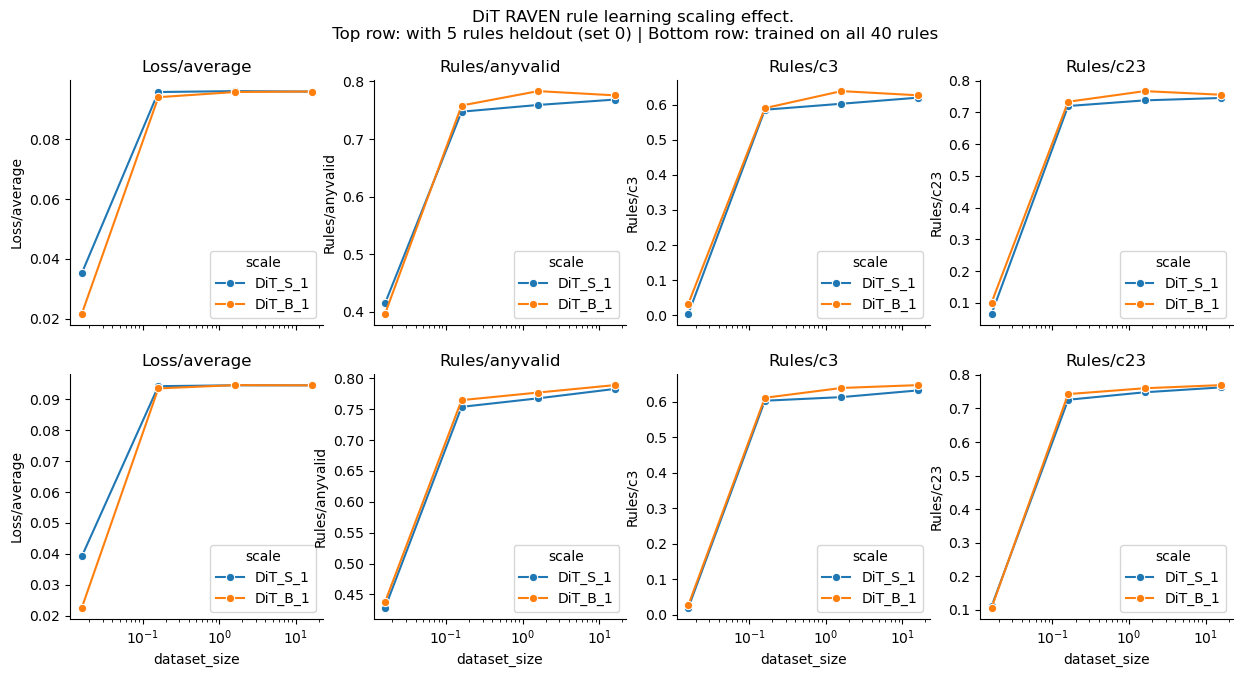

In [41]:
syndf_DiT_sorted = syndf_DiT.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for ax, metric in zip(axs[0,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_DiT_sorted[syndf_DiT_sorted.heldout==True], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_DiT[syndf_DiT.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["DiT_S_1", "DiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
for ax, metric in zip(axs[1,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_DiT_sorted[syndf_DiT_sorted.heldout==False], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_DiT[syndf_DiT.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["DiT_S_1", "DiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
plt.suptitle("DiT RAVEN rule learning scaling effect.\n Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "DiT_raven_rule_learning_scaling_effect", fig)
plt.show()

### General Learning Dynamics

In [ ]:
for expfullname in syndf_DiT.full_name:
    tb_record = tb_data_col_DiT[expfullname]
    expname = expfullname.split("/")[0]
    print(expfullname)
    # print(tb_record.keys())
    # print(tb_record['tag'].unique())    
    tb_anyvalid = tb_record[tb_record.tag=='Val/AnyValid']
    tb_anyvalid["anyvalid_renorm"] = (tb_anyvalid["value"] - 2/3) * 3
    figh = plt.figure(figsize=(6, 5))
    sns.lineplot(data=tb_anyvalid, x='step', y='anyvalid_renorm', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Val/C3'], x='step', y='value', label='C3')
    # sns.lineplot(data=tb_record[tb_record.tag=='Val/AnyValid'], x='step', y='value', label='AnyValid')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/anyvalid'], x='step', y='value', label='AnyValid_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/c3'], x='step', y='value', label='C3_abinit')
    sns.lineplot(data=tb_record[tb_record.tag=='Rules/c2'], x='step', y='value', label='C2_abinit')
    plt.legend() # ['Val/C3', 'Val/C3_abinit', 'Val/C2_abinit', 'Val/AnyValid_abinit']
    plt.title(expname)
    saveallforms(DiTfigdir, f"{expname}_valid_consist_summary", figh)
    plt.show()
    # raise ValueError

### Load individual epochs and plot rule learning dynamics 

In [ ]:
for expfullname in syndf_DiT.full_name:
    tb_record = tb_data_col_DiT[expfullname]
    expname = expfullname.split("/tensorboard_logs")[0]
    prefix = "sample_rule_eval_" #"eval_step" if "stream" in expname else "eval_epoch"
    eval_col = sweep_collect_eval_data(expname, DiT_exproot, prefix=prefix)
    epoch_list, rule_list_all, consistency_all = extract_rule_list_from_eval_col_Diffusion(eval_col, )
    rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all, consistency_all)
    eval_sample_num = rule_list_all.shape[1]
    print(expname)
    if "heldout0" in expname:
        heldout_id = [1, 16, 20, 34, 37]  
    else:
        heldout_id = []

    figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                            titlestr=f"{expname}\nValid rule count separated by rule type")
    saveallforms(DiTfigdir, f"{expname}_indiv_rule_validity", figh)

    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
    figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                        titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
    saveallforms(DiTfigdir, f"{expname}_indiv_rule_consistency", figh)
    
    figh = visualize_train_heldout_rule(epoch_list, rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num * 3, reflevel=1 / 40,
                                titlestr=f"{expname}\nValid rule fraction")
    saveallforms(DiTfigdir, f"{expname}_train_held_rule_validity", figh)

    figh = visualize_train_heldout_rule(epoch_list, cons3_rule_cnt_mat, heldout_id, 
                                normalizer=eval_sample_num, reflevel=1 / 40,
                                titlestr=f"{expname}\nC3 sample fraction")
    saveallforms(DiTfigdir, f"{expname}_train_held_rule_consistency", figh)

In [107]:
import torch
for expname in [
    "094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205", 
    "093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205", 
    "095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205", 
    "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204", 
    "089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204", 
    "088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204", 
    "085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204", 
    "086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204", 
    # "083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149", 
    "087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204", 
    "096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205", 
    "092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205", 
    # "084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200", 
    "091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205", ]:
    assert os.path.exists(join(DiT_exproot, expname, "tensorboard_logs")), expname  
    # for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
    epoch_num = max([int(f.split("sample_rule_eval_")[-1].split(".pt")[0]) for f in os.listdir(join(DiT_exproot, expname,'samples'))])
    print(epoch_num)
    samples_eval = torch.load(join(DiT_exproot, expname, 'samples', f"sample_rule_eval_{epoch_num}.pt"))

1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000
1000000


In [133]:
# for expname in [
#     "094-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_20240711-0205", 
#     "093-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_heldout0_20240711-0205", 
#     "095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205", 
#     "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204", 
#     "089-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_heldout0_20240711-0204", 
#     "088-RAVEN10_abstract-uncond-DiT_S_1-stream16M_heldout0_20240711-0204", 
#     "085-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_20240711-0204", 
#     "086-RAVEN10_abstract-uncond-DiT_S_1-stream1_6M_20240711-0204", 
#     # "083-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0149", 
#     "087-RAVEN10_abstract-uncond-DiT_S_1-stream16M_20240711-0204", 
#     "096-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_20240711-0205", 
#     "092-RAVEN10_abstract-uncond-DiT_B_1-stream1_6M_20240711-0205", 
#     # "084-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0200", 
#     "091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205", ]:
expname = "091-RAVEN10_abstract-uncond-DiT_B_1-stream16M_20240711-0205"
expname = "095-RAVEN10_abstract-uncond-DiT_B_1-stream16M_heldout0_20240711-0205"
assert os.path.exists(join(DiT_exproot, expname, "tensorboard_logs")), expname  
# for files with names like 'sample_rule_eval_995000.pt' find the one with largest number
epoch_nums = sorted([int(f.split("sample_rule_eval_")[-1].split(".pt")[0]) for f in os.listdir(join(DiT_exproot, expname,'samples'))])
eval_col = {}
for epoch_num in tqdm(epoch_nums):
    samples_eval = torch.load(join(DiT_exproot, expname, 'samples', f"sample_rule_eval_{epoch_num}.pt"))
    eval_col[epoch_num] = samples_eval

1000000


100%|██████████| 802/802 [00:39<00:00, 20.22it/s]


In [116]:
list(eval_col[1])

['c3_list', 'c2_list', 'rule_col', 'c3_cnt', 'c2_cnt', 'anyvalid_cnt', 'total']

In [141]:
epoch_list = list(eval_col.keys())
rule_list_all = []
consistency_all = []
for epoch in eval_col.keys():
    rule_list_all.append(eval_col[epoch]["rule_col"])
    consistency_all.append((eval_col[epoch]["c3_list"], eval_col[epoch]["c2_list"]))
rule_list_all = np.array(rule_list_all, dtype=object)
consistency_all = np.array(consistency_all, dtype=object)
print(rule_list_all.shape, consistency_all.shape)


(401, 2048, 3) (401, 2, 2048)


In [ ]:
# each element in the rule rule_pool_all is a list of rules for all the samples in the corresponding generation
rule_pool_all = []
for i in trange(len(epoch_list)):
    rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
    rule_pool_all.append(rule_pool)
# plot the number of rules == rule_i for each generation
rule_cnt_mat = np.zeros((len(epoch_list), 40))
for i in trange(len(epoch_list)):
    rule_pool = rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    rule_cnt_mat[i, rule_uniq] = counts

cons3_rule_pool_all = []
cons2_rule_pool_all = []
for i in trange(len(epoch_list)):
    rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
    cons3_rule_pool_all.append(rule_pool)
    rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
    cons2_rule_pool_all.append(rule_pool)

cons3_rule_cnt_mat = np.zeros((len(epoch_list), 40))
cons2_rule_cnt_mat = np.zeros((len(epoch_list), 40))
for i in trange(len(epoch_list)):
    rule_pool = cons3_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons3_rule_cnt_mat[i, rule_uniq] = counts
    rule_pool = cons2_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons2_rule_cnt_mat[i, rule_uniq] = counts
    
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []
figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"
figh, axs = visualize_indiv_rule_dynam(epoch_list, rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                        titlestr=f"{expname}\nValid rule count separated by rule type")
saveallforms(figdir, f"{expname}_indiv_rule_validity", figh)


figh, axs = visualize_indiv_rule_dynam(epoch_list, cons3_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(epoch_list, cons2_rule_cnt_mat, conv_wid=10, heldout_id=heldout_id,
                                       titlestr=f"{expname}\nConsistency 3 (blue) and 2 (orange) rule count", axs=axs)
saveallforms(figdir, f"{expname}_indiv_rule_consistency", figh)


In [111]:
len([int(f.split("sample_rule_eval_")[-1].split(".pt")[0]) for f in os.listdir(join(DiT_exproot, expname,'samples'))])

802

## SiT

In [42]:
tb_data_col_SiT = extract_all_runs(SiT_exproot)

Extracted data from 017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Extracted data from 013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 018-SiT_B_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 020-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 016-SiT_B_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs
Extracted data from 021-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
Extracted data from 015-SiT_B_1-str

In [43]:
for key in sorted(tb_data_col_SiT.keys()):
    if tb_data_col_SiT[key]["step"].max() < 999999:
        print(key)
        print(tb_data_col_SiT[key]["step"].max(), "steps, unfinished run")

004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
875000 steps, unfinished run
005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
875000 steps, unfinished run
011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs
942500 steps, unfinished run
012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
815200 steps, unfinished run
013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs
979500 steps, unfinished run
014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
975000 steps, unfinished run


In [48]:
runnames = list(k[4:].replace("-Linear-velocity-None/tensorboard_logs","") for k in tb_data_col_SiT.keys() if "pilot" not in k)

In [44]:
excluded_runs = [
    "004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs",
    "005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs",
    "011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs", # 942500 steps, unfinished run
    "012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs", # 815200 steps, unfinished run
    "013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs", # 979500 steps, unfinished run
    "014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs", # 975000 steps, unfinished run
]
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_SiT = extract_last_step_summary(tb_data_col_SiT, simplify_runname, excluded_runs)
syndf_SiT = syndf_SiT.sort_index()
syndf_SiT

Excluding 004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Excluding 012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Excluding 014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
Excluding 005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Excluding 013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs
Excluding 011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs


tag,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,step,step/epoch
run_name,,,,,,,,,,,,
006-SiT_S_1-stream0_016M_all-Linear-velocity-None,0.513552,0.468938,0.499837,3071.0,0.097168,199.0,0.022949,47.0,16.666367,006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs,1000000,1000000
007-SiT_S_1-stream0_16M_all-Linear-velocity-None,0.792181,0.792535,0.846842,5203.0,0.118652,243.0,0.725098,1485.0,13.036997,007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs,1000000,1000000
008-SiT_S_1-stream1_6M_all-Linear-velocity-None,0.796287,0.785929,0.885417,5440.0,0.114258,234.0,0.775391,1588.0,17.617640,008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs,1000000,1000000
010-SiT_S_1-stream16M_all-Linear-velocity-None,0.796884,0.830317,0.875488,5379.0,0.109375,224.0,0.763184,1563.0,9.326361,010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs,1000000,1000000
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None,0.804236,0.827832,0.870117,5346.0,0.110840,227.0,0.757812,1552.0,20.039679,011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs,1000000,1000000
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None,0.801265,0.809084,0.886393,5446.0,0.124023,254.0,0.770996,1579.0,19.949865,012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs,1000000,1000000
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None,0.494431,0.532683,0.456868,2807.0,0.080566,165.0,0.012695,26.0,16.838747,013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,1000000,1000000
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None,0.800243,0.843793,0.845378,5194.0,0.125488,257.0,0.711914,1458.0,20.022507,014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs,1000000,1000000
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None,0.412909,0.375841,0.524902,3225.0,0.096191,197.0,0.160645,329.0,8.258395,015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,1000000,1000000


In [46]:
syndf_SiT.to_csv(join(tabdir, "SiT_raven_tensorboard_data.csv"))
pkl.dump(tb_data_col_SiT, open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "wb"))

In [47]:
excluded_runs = [
    "004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs",
    "005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs",
    "011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs", # 942500 steps, unfinished run
    "012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs", # 815200 steps, unfinished run
    "013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs", # 979500 steps, unfinished run
    "014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs", # 975000 steps, unfinished run
]
simplify_runname = lambda x: x.replace("/tensorboard_logs", "").split("_2024")[0].replace("RAVEN10_abstract-", "")
syndf_SiT_std = extract_last_K_step_avg_summary(tb_data_col_SiT, simplify_runname, exclude_runs=excluded_runs, K=10, compute_std=True)
syndf_SiT_std = syndf_SiT_std.sort_index()
syndf_SiT_std.to_csv(join(tabdir, "SiT_raven_tensorboard_data_last10.csv"))
syndf_SiT_std

Excluding 004-SiT_S_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Excluding 012-SiT_B_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs
Excluding 014-SiT_B_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs
Excluding 005-SiT_B_1-stream0_16M_pilot-Linear-velocity-None/tensorboard_logs
Excluding 013-SiT_B_1-stream16M_all-Linear-velocity-None/tensorboard_logs
Excluding 011-SiT_B_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs


,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,...,step/epoch,Loss/average_std,Loss/batch_std,Rules/anyvalid_std,Rules/anyvalid_cnt_std,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std,Speed/steps_per_sec_std
run_name,,,,,,,,,,,,,,,,,,,,,
006-SiT_S_1-stream0_016M_all-Linear-velocity-None,0.515942,0.506911,0.500635,3075.9,0.097559,199.8,0.016650,34.1,17.081602,006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs,...,977500,0.006074,0.032274,0.007306,44.891103,0.004045,8.283853,0.002897,5.933895,0.737130
007-SiT_S_1-stream0_16M_all-Linear-velocity-None,0.794220,0.773342,0.846305,5199.7,0.120801,247.4,0.722168,1479.0,18.578108,007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs,...,977500,0.003117,0.025224,0.001862,11.441154,0.003470,7.105553,0.004343,8.894443,2.898249
008-SiT_S_1-stream1_6M_all-Linear-velocity-None,0.796578,0.788204,0.883431,5427.8,0.111279,227.9,0.773389,1583.9,19.665982,008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs,...,977500,0.003032,0.039944,0.001389,8.534896,0.003976,8.143846,0.003657,7.489993,0.719731
010-SiT_S_1-stream16M_all-Linear-velocity-None,0.796583,0.803868,0.876318,5384.1,0.105713,216.5,0.768164,1573.2,18.850724,010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs,...,977500,0.002970,0.029069,0.001100,6.756889,0.003867,7.919736,0.002873,5.884065,3.347152
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None,0.804104,0.799794,0.869320,5341.1,0.113135,231.7,0.753564,1543.3,20.047720,011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs,...,977500,0.002334,0.031407,0.001699,10.439774,0.002447,5.012207,0.002059,4.217688,0.010945
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None,0.804023,0.795016,0.885319,5439.4,0.129004,264.2,0.765576,1567.9,20.024264,012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs,...,977500,0.002747,0.035710,0.001601,9.834181,0.004827,9.886017,0.003909,8.006248,0.026427
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None,0.494303,0.484189,0.457031,2808.0,0.082373,168.7,0.015088,30.9,17.163987,013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,...,977500,0.002352,0.042111,0.002651,16.289056,0.005224,10.698390,0.001270,2.601282,0.616000
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None,0.800377,0.798300,0.843669,5183.5,0.126416,258.9,0.708887,1451.8,19.669046,014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs,...,977500,0.002453,0.027966,0.002183,13.410195,0.002738,5.606544,0.002229,4.565572,0.718519
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None,0.410817,0.415985,0.517204,3177.7,0.096777,198.2,0.153223,313.8,8.303554,015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,...,977500,0.003453,0.035983,0.005449,33.479845,0.005863,12.007405,0.003482,7.130529,0.145119


### Overall scaling curve

In [48]:
syndf_SiT = pd.read_csv(join(tabdir, "SiT_raven_tensorboard_data_last10.csv"), index_col=0)
tb_data_col_SiT = pkl.load(open(join(tabdir, "SiT_raven_tensorboard_raw_data.pkl"), "rb"))

In [49]:
syndf_SiT["dataset_size"] = syndf_SiT.index.map(extract_and_convert)
syndf_SiT["heldout"] = syndf_SiT.index.map(lambda x: "_heldout0" in x)
syndf_SiT["scale"] = syndf_SiT.index.map(lambda x: "SiT_B_1" if "SiT_B_1" in x else "SiT_S_1" if "SiT_S_1" in x else None)
syndf_SiT["Rules/c23"] = syndf_SiT["Rules/c2"] + syndf_SiT["Rules/c3"]
syndf_SiT["Rules/c23_cnt"] = syndf_SiT["Rules/c2_cnt"] + syndf_SiT["Rules/c3_cnt"]

In [50]:
syndf_SiT

,Loss/average,Loss/batch,Rules/anyvalid,Rules/anyvalid_cnt,Rules/c2,Rules/c2_cnt,Rules/c3,Rules/c3_cnt,Speed/steps_per_sec,full_name,...,Rules/c2_std,Rules/c2_cnt_std,Rules/c3_std,Rules/c3_cnt_std,Speed/steps_per_sec_std,dataset_size,heldout,scale,Rules/c23,Rules/c23_cnt
run_name,,,,,,,,,,,,,,,,,,,,,
006-SiT_S_1-stream0_016M_all-Linear-velocity-None,0.515942,0.506911,0.500635,3075.9,0.097559,199.8,0.016650,34.1,17.081602,006-SiT_S_1-stream0_016M_all-Linear-velocity-None/tensorboard_logs,...,0.004045,8.283853,0.002897,5.933895,0.737130,0.016,False,SiT_S_1,0.114209,233.9
007-SiT_S_1-stream0_16M_all-Linear-velocity-None,0.794220,0.773342,0.846305,5199.7,0.120801,247.4,0.722168,1479.0,18.578108,007-SiT_S_1-stream0_16M_all-Linear-velocity-None/tensorboard_logs,...,0.003470,7.105553,0.004343,8.894443,2.898249,0.160,False,SiT_S_1,0.842969,1726.4
008-SiT_S_1-stream1_6M_all-Linear-velocity-None,0.796578,0.788204,0.883431,5427.8,0.111279,227.9,0.773389,1583.9,19.665982,008-SiT_S_1-stream1_6M_all-Linear-velocity-None/tensorboard_logs,...,0.003976,8.143846,0.003657,7.489993,0.719731,1.600,False,SiT_S_1,0.884668,1811.8
010-SiT_S_1-stream16M_all-Linear-velocity-None,0.796583,0.803868,0.876318,5384.1,0.105713,216.5,0.768164,1573.2,18.850724,010-SiT_S_1-stream16M_all-Linear-velocity-None/tensorboard_logs,...,0.003867,7.919736,0.002873,5.884065,3.347152,16.000,False,SiT_S_1,0.873877,1789.7
011-SiT_S_1-stream16M_heldout0-Linear-velocity-None,0.804104,0.799794,0.869320,5341.1,0.113135,231.7,0.753564,1543.3,20.047720,011-SiT_S_1-stream16M_heldout0-Linear-velocity-None/tensorboard_logs,...,0.002447,5.012207,0.002059,4.217688,0.010945,16.000,True,SiT_S_1,0.866699,1775.0
012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None,0.804023,0.795016,0.885319,5439.4,0.129004,264.2,0.765576,1567.9,20.024264,012-SiT_S_1-stream1_6M_heldout0-Linear-velocity-None/tensorboard_logs,...,0.004827,9.886017,0.003909,8.006248,0.026427,1.600,True,SiT_S_1,0.894580,1832.1
013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None,0.494303,0.484189,0.457031,2808.0,0.082373,168.7,0.015088,30.9,17.163987,013-SiT_S_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,...,0.005224,10.698390,0.001270,2.601282,0.616000,0.016,True,SiT_S_1,0.097461,199.6
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None,0.800377,0.798300,0.843669,5183.5,0.126416,258.9,0.708887,1451.8,19.669046,014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None/tensorboard_logs,...,0.002738,5.606544,0.002229,4.565572,0.718519,0.160,True,SiT_S_1,0.835303,1710.7
015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None,0.410817,0.415985,0.517204,3177.7,0.096777,198.2,0.153223,313.8,8.303554,015-SiT_B_1-stream0_016M_heldout0-Linear-velocity-None/tensorboard_logs,...,0.005863,12.007405,0.003482,7.130529,0.145119,0.016,True,SiT_B_1,0.250000,512.0


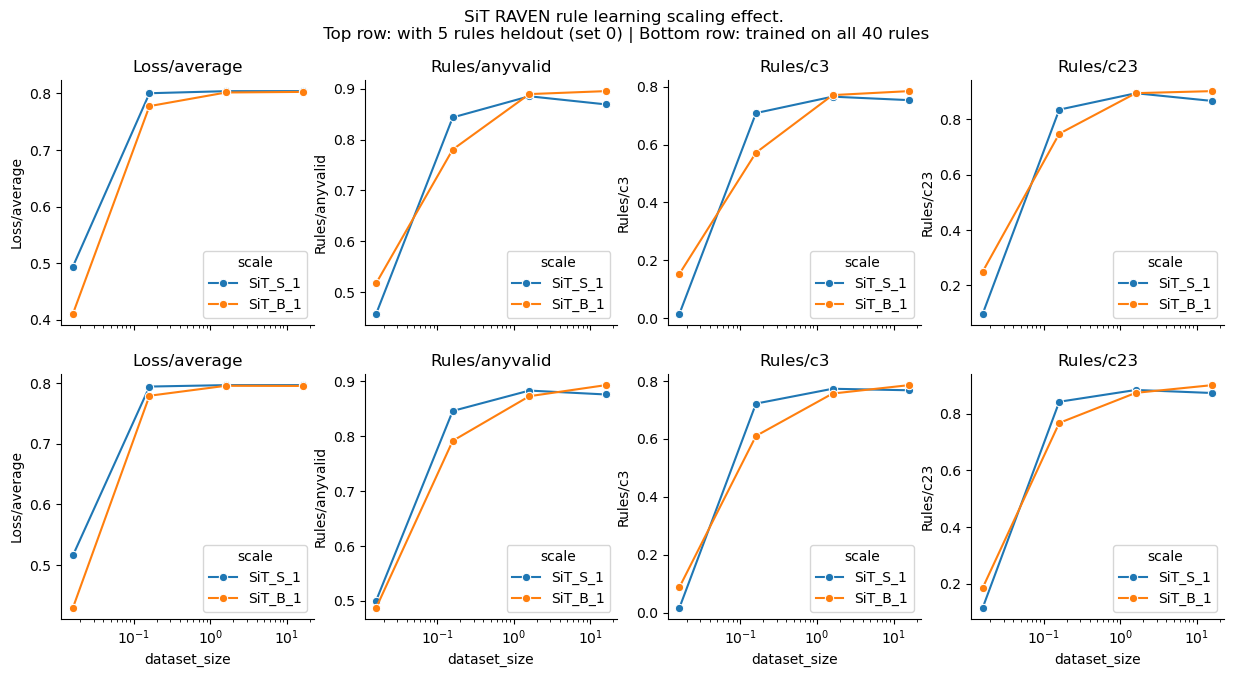

In [51]:
syndf_SiT_sorted = syndf_SiT.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for ax, metric in zip(axs[0,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_SiT_sorted[syndf_SiT_sorted.heldout==True], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_SiT[syndf_SiT.heldout==True], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
for ax, metric in zip(axs[1,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    # sns.barplot(data=syndf_SiT_sorted[syndf_SiT_sorted.heldout==False], x="scale", y=metric, hue="dataset_size", ax=ax)
    sns.lineplot(data=syndf_SiT[syndf_SiT.heldout==False], x="dataset_size", y=metric, hue="scale", ax=ax, marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
plt.suptitle("SiT RAVEN rule learning scaling effect.\n Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "SiT_raven_rule_learning_scaling_effect", fig)
plt.show()

## Synopsis across model families

In [52]:
# load tables from the three families and concatenate them
syndf_EDM = pd.read_csv(join(tabdir, "EDM_raven_tensorboard_data_last10.csv"), index_col=0)
syndf_DiT = pd.read_csv(join(tabdir, "DiT_raven_tensorboard_data_last10.csv"), index_col=0)
syndf_SiT = pd.read_csv(join(tabdir, "SiT_raven_tensorboard_data_last10.csv"), index_col=0)
syndf_DiT["model_class"] = "DiT"
syndf_SiT["model_class"] = "SiT"
syndf_EDM["model_class"] = "EDM"
syndf_diff = pd.concat([syndf_EDM, syndf_DiT, syndf_SiT], axis=0)

In [55]:
syndf_diff
syndf_diff["dataset_size"] = syndf_diff.index.map(extract_and_convert)
syndf_diff["heldout"] = syndf_diff.index.map(lambda x: "_heldout0" in x)
syndf_diff["Rules/c23"] = syndf_diff["Rules/c2"] + syndf_diff["Rules/c3"]
syndf_diff["Rules/c23_cnt"] = syndf_diff["Rules/c2_cnt"] + syndf_diff["Rules/c3_cnt"]
syndf_diff["scale"] = None
syndf_diff.loc[syndf_diff.model_class=="EDM", "scale"] = syndf_diff[syndf_diff.model_class=="EDM"].index.map(lambda x: "EDMx3" if "BigBlnrX3" in x else "EDMx2" if "WideBlnrX3" in x else "EDMx1" if "BaseBlnrX3" in x else None)
syndf_diff.loc[syndf_diff.model_class=="DiT", "scale"] = syndf_diff[syndf_diff.model_class=="DiT"].index.map(lambda x: "DiT-B/1" if "DiT_B_1" in x else "DiT-S/1" if "DiT_S_1" in x else None)
syndf_diff.loc[syndf_diff.model_class=="SiT", "scale"] = syndf_diff[syndf_diff.model_class=="SiT"].index.map(lambda x: "SiT-B/1" if "SiT_B_1" in x else "SiT-S/1" if "SiT_S_1" in x else None)

In [56]:
# evaluate the CI of rates
from stats_plot_utils import estimate_CI

syndf_diff["c3_CI_L"], syndf_diff["c3_CI_H"] = estimate_CI(syndf_diff["Rules/c3_cnt"] * 10, 10 * 2048, 0.05)
syndf_diff["c23_CI_L"], syndf_diff["c23_CI_H"] = estimate_CI(syndf_diff["Rules/c23_cnt"] * 10, 10 * 2048, 0.05)
syndf_diff["c2_CI_L"], syndf_diff["c2_CI_H"] = estimate_CI(syndf_diff["Rules/c2_cnt"] * 10, 10 * 2048, 0.05)
syndf_diff["valid_CI_L"], syndf_diff["valid_CI_H"] = estimate_CI(syndf_diff["Rules/anyvalid_cnt"] * 10, 3 * 10 * 2048, 0.05)

In [57]:
syndf_diff.to_csv(join(tabdir, "diffusion_family_comb_tensorboard_data_last10.csv"))    

In [78]:
syndf_diff.query("""dataset_size == 0.16 and heldout == True""")\
    [["dataset_size", "heldout", "step", "model_class", "scale", "Rules/anyvalid", "Rules/c3", "Rules/c23"]]

,dataset_size,heldout,step,model_class,scale,Rules/anyvalid,Rules/c3,Rules/c23
run_name,,,,,,,,
BaseBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx1,0.647087,0.259082,0.492920
BigBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx3,0.704215,0.409961,0.647607
BigBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx3,0.699447,0.408447,0.650195
WideBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx2,0.714290,0.445654,0.663428
090-uncond-DiT_S_1-stream0_16M_heldout0,0.16,True,1000000,DiT,DiT-S/1,0.747510,0.585352,0.720068
094-uncond-DiT_B_1-stream0_16M_heldout0,0.16,True,1000000,DiT,DiT-B/1,0.758219,0.589893,0.733496
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None,0.16,True,1000000,SiT,SiT-S/1,0.843669,0.708887,0.835303
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None,0.16,True,1000000,SiT,SiT-B/1,0.780518,0.572119,0.748291


In [79]:
syndf_diff.query("""dataset_size == 0.16 and heldout == True""")\
    [["dataset_size", "heldout", "step", "model_class", "scale", "valid_CI_L", "valid_CI_H", "c3_CI_L", "c3_CI_H", "c23_CI_L", "c23_CI_H"]]

,dataset_size,heldout,step,model_class,scale,valid_CI_L,valid_CI_H,c3_CI_L,c3_CI_H,c23_CI_L,c23_CI_H
run_name,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx1,0.643311,0.650863,0.253076,0.265088,0.486084,0.499756
BigBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx3,0.700602,0.707829,0.403223,0.416699,0.641064,0.654150
BigBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx3,0.695817,0.703076,0.401709,0.415186,0.643652,0.656738
WideBlnrX3_new_stream0_16M_heldout0,0.16,True,999999,EDM,EDMx2,0.710710,0.717855,0.438867,0.452441,0.656934,0.669873
090-uncond-DiT_S_1-stream0_16M_heldout0,0.16,True,1000000,DiT,DiT-S/1,0.744076,0.750944,0.578613,0.592090,0.713916,0.726221
094-uncond-DiT_B_1-stream0_16M_heldout0,0.16,True,1000000,DiT,DiT-B/1,0.754834,0.761605,0.583154,0.596631,0.727441,0.739551
014-SiT_S_1-stream0_16M_heldout0-Linear-velocity-None,0.16,True,1000000,SiT,SiT-S/1,0.840788,0.846533,0.702637,0.715088,0.830225,0.840381
017-SiT_B_1-stream0_16M_heldout0-Linear-velocity-None,0.16,True,1000000,SiT,SiT-B/1,0.777246,0.783789,0.565332,0.578906,0.742334,0.754199


In [80]:
syndf_diff.query("""dataset_size == 0.16 and heldout == False""")\
    [["dataset_size", "heldout", "step", "model_class", "scale", "Rules/anyvalid", "Rules/c3", "Rules/c23"]]

,dataset_size,heldout,step,model_class,scale,Rules/anyvalid,Rules/c3,Rules/c23
run_name,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx1,0.641960,0.232520,0.467432
BigBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx3,0.722949,0.458154,0.680859
WideBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx2,0.735970,0.480225,0.690283
085-uncond-DiT_S_1-stream0_16M,0.16,False,1000000,DiT,DiT-S/1,0.753874,0.602930,0.725879
096-uncond-DiT_B_1-stream0_16M,0.16,False,1000000,DiT,DiT-B/1,0.764779,0.611182,0.742773
007-SiT_S_1-stream0_16M_all-Linear-velocity-None,0.16,False,1000000,SiT,SiT-S/1,0.846305,0.722168,0.842969
020-SiT_B_1-stream0_16M_all-Linear-velocity-None,0.16,False,1000000,SiT,SiT-B/1,0.791878,0.610547,0.768115


In [81]:
syndf_diff.query("""dataset_size == 0.16 and heldout == False""")\
    [["dataset_size", "heldout", "step", "model_class", "scale", "valid_CI_L", "valid_CI_H", "c3_CI_L", "c3_CI_H", "c23_CI_L", "c23_CI_H"]]

,dataset_size,heldout,step,model_class,scale,valid_CI_L,valid_CI_H,c3_CI_L,c3_CI_H,c23_CI_L,c23_CI_H
run_name,,,,,,,,,,,
BaseBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx1,0.638167,0.645752,0.226758,0.238330,0.460596,0.474268
BigBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx3,0.719401,0.726481,0.451318,0.464990,0.674463,0.687256
WideBlnrX3_new_stream0_16M,0.16,False,999999,EDM,EDMx2,0.732487,0.739453,0.473389,0.487061,0.683936,0.696631
085-uncond-DiT_S_1-stream0_16M,0.16,False,1000000,DiT,DiT-S/1,0.750456,0.757275,0.596240,0.609619,0.719775,0.731982
096-uncond-DiT_B_1-stream0_16M,0.16,False,1000000,DiT,DiT-B/1,0.761426,0.768132,0.604492,0.617871,0.736768,0.748730
007-SiT_S_1-stream0_16M_all-Linear-velocity-None,0.16,False,1000000,SiT,SiT-S/1,0.843441,0.849154,0.716016,0.728271,0.837988,0.847949
020-SiT_B_1-stream0_16M_all-Linear-velocity-None,0.16,False,1000000,SiT,SiT-B/1,0.788656,0.795085,0.603857,0.617236,0.762305,0.773877


### Synopsis bar plot

In [85]:
finalplot_tab.scale.values

array(['EDMx1', 'EDMx3', 'EDMx3', 'EDMx2', 'DiT-S/1', 'DiT-B/1',
       'SiT-S/1', 'SiT-B/1'], dtype=object)

In [82]:
finalplot_tab = syndf_diff.query("""dataset_size == 0.16 and heldout == True""")\
    [["dataset_size", "heldout", "step", "model_class", "scale", "Rules/anyvalid", "Rules/c3", "Rules/c23"]]

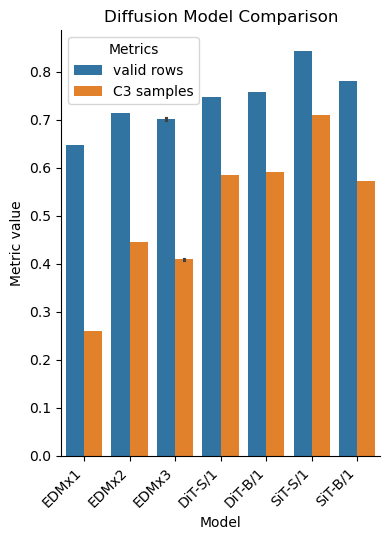

In [89]:
plot_data = finalplot_tab[['scale', 'Rules/anyvalid', 'Rules/c3', ]]#'''r2_ratio'
# remove the row with "EDMx2*" model
plot_data = plot_data[plot_data['scale'] != 'EDMx2*']
# rename column names valid -> valid row, C3 -> C3 sample
plot_data.columns = ['model', 'valid rows', 'C3 samples']
# Melting the data to long format suitable for sns.barplot
plot_data_melted = plot_data.melt(id_vars=['model'], var_name='Metric', value_name='Value')
# Creating the bar plot
plt.figure(figsize=(4, 5.5))
bar_plot = sns.barplot(x='model', y='Value', hue='Metric', data=plot_data_melted, 
                       order=['EDMx1', 'EDMx2', 'EDMx3', 'DiT-S/1', 'DiT-B/1', 'SiT-S/1', 'SiT-B/1'])
                    #    order=["GPT2-S", "GPT2-B", "GPT2-M", "SSMx1", "SSMx2", "SSMx3"],)
                       #order=["GPT2CmbEmb_base", "GPT2_base", "GPT2_medium", "Mamba_base", "mamba_medium", "mamba_big"])
plt.title('Diffusion Model Comparison')
plt.xlabel('Model')
plt.ylabel('Metric value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
# Show the plot
plt.tight_layout()
# plt.ylim(0.0, 0.77)
saveallforms(synopsisdir, 'Diffusion_abinit_model_comparison_barplot_ylim_new')
# print(plt.ylim()) # (0.0, 0.8858520528674125)
plt.show()


### Synopsis scaling curve

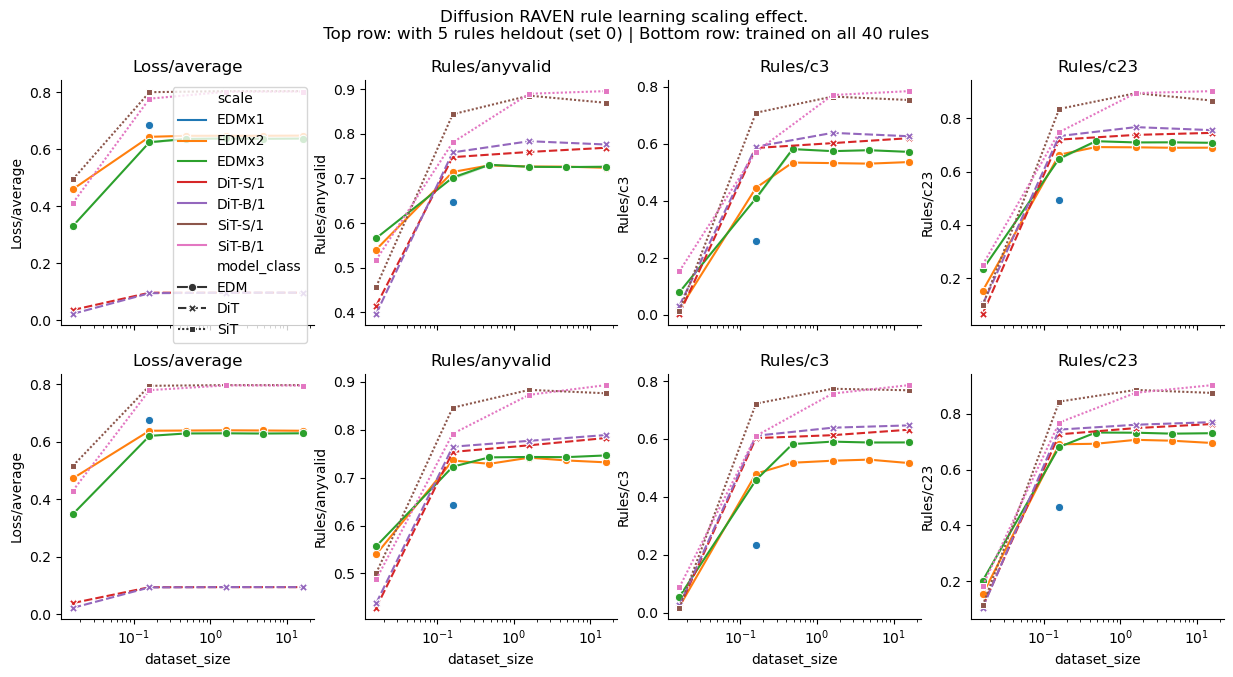

In [71]:
syndf_diff_sorted = syndf_diff.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for ax, metric in zip(axs[0,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==True], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, 
                 legend=True if ax == axs[0,0] else False,
                 hue_order=["EDMx1","EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
for ax, metric in zip(axs[1,:], ["Loss/average", "Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==False], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, legend=False,
                 hue_order=["EDMx1","EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
    # turn off legend
    
plt.suptitle("Diffusion RAVEN rule learning scaling effect.\n Top row: with 5 rules heldout (set 0) | Bottom row: trained on all 40 rules")
saveallforms(synopsisdir, "diffusion_family_raven_rule_learning_scaling_effect", fig)
plt.show()

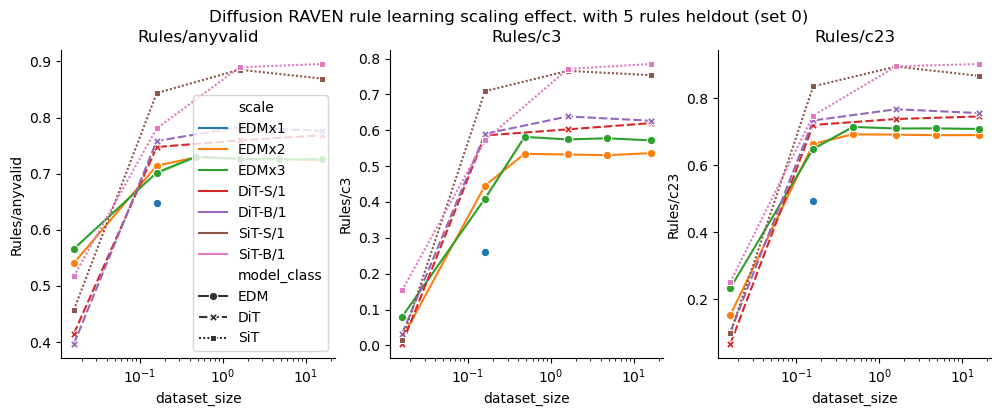

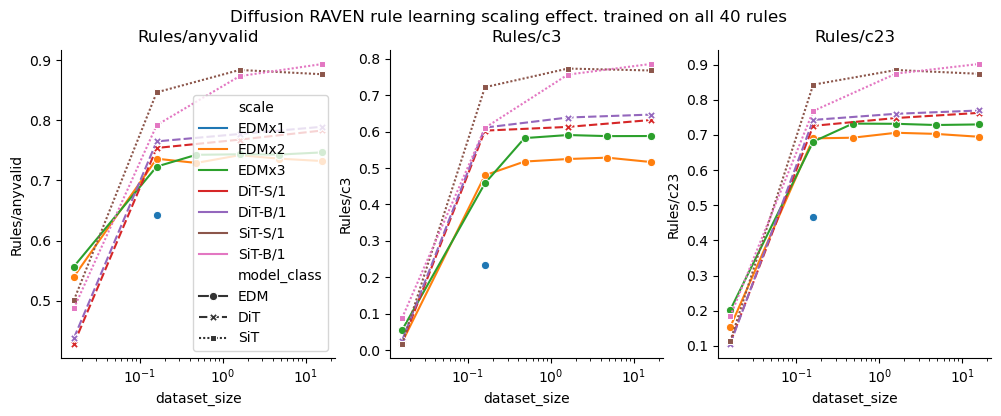

In [74]:
syndf_diff_sorted = syndf_diff.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==True], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, 
                 legend=True if ax == axs[0,0] else False,
                 hue_order=["EDMx1","EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
    
plt.suptitle("Diffusion RAVEN rule learning scaling effect. with 5 rules heldout (set 0) ") #| Bottom row: trained on all 40 rules
saveallforms(synopsisdir, "diffusion_family_raven_rule_learning_scaling_effect_rules_healdout", fig)
plt.show()

syndf_diff_sorted = syndf_diff.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==False], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, 
                 legend=True if ax == axs[0,0] else False,
                 hue_order=["EDMx1","EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
    
plt.suptitle("Diffusion RAVEN rule learning scaling effect. trained on all 40 rules ") #| Bottom row: 
saveallforms(synopsisdir, "diffusion_family_raven_rule_learning_scaling_effect_rules_allrules", fig)
plt.show()

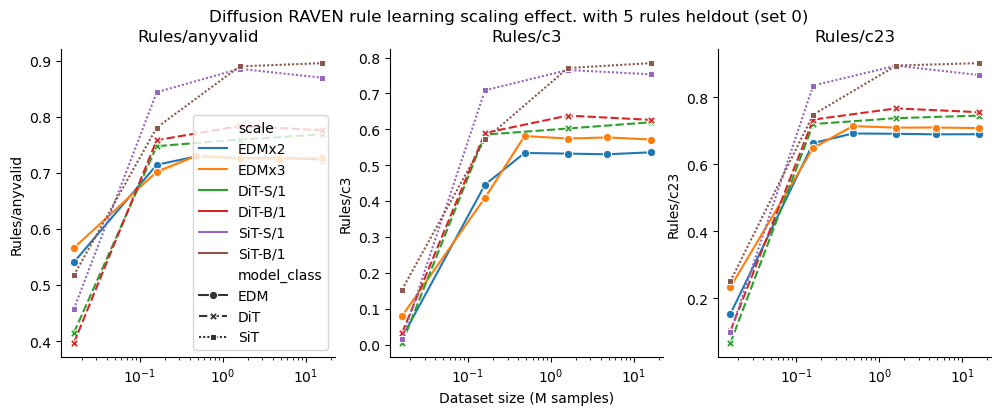

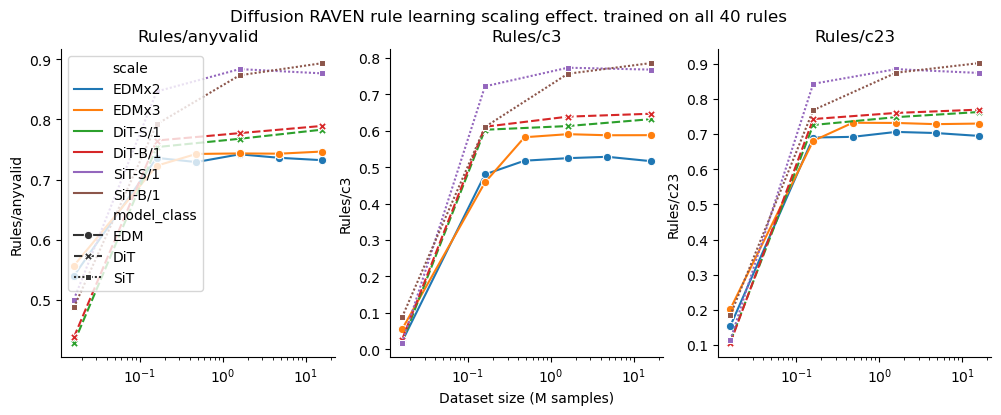

In [76]:
syndf_diff_sorted = syndf_diff.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==True], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, 
                 legend=True if ax == axs[0,0] else False,
                 hue_order=["EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
    if ax == axs[0,1]:
        ax.set_xlabel("Dataset size (M samples)")
    else:
        ax.set_xlabel("")
    
plt.suptitle("Diffusion RAVEN rule learning scaling effect. with 5 rules heldout (set 0) ") #| Bottom row: trained on all 40 rules
saveallforms(synopsisdir, "diffusion_family_raven_rule_learning_scaling_effect_rules_healdout_prune", fig)
plt.show()

syndf_diff_sorted = syndf_diff.sort_values(by=["heldout", "scale", "dataset_size", ], ascending=[True, False, True, ])
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, squeeze=False)
for ax, metric in zip(axs[0,:], ["Rules/anyvalid", "Rules/c3", "Rules/c23",]):
    sns.lineplot(data=syndf_diff[syndf_diff.heldout==False], x="dataset_size", y=metric, hue="scale", style="model_class", ax=ax, markers=True, 
                 legend=True if ax == axs[0,0] else False,
                 hue_order=["EDMx2","EDMx3","DiT-S/1", "DiT-B/1","SiT-S/1", "SiT-B/1"]) # marker="o", hue_order=["SiT_S_1", "SiT_B_1"])
    ax.set_title(metric)
    ax.set_xscale('log')
    if ax == axs[0,1]:
        ax.set_xlabel("Dataset size (M samples)")
    else:
        ax.set_xlabel("")
    
plt.suptitle("Diffusion RAVEN rule learning scaling effect. trained on all 40 rules ") #| Bottom row: 
saveallforms(synopsisdir, "diffusion_family_raven_rule_learning_scaling_effect_rules_allrules_prune", fig)
plt.show()

In [77]:
synopsisdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_model_synopsis'

In [113]:
syndf_diff[["scale", "model_class", "dataset_size", "heldout", "Rules/anyvalid", "Rules/c3", "Rules/c23"]]

,scale,model_class,dataset_size,heldout,Rules/anyvalid,Rules/c3,Rules/c23
run_name,,,,,,,
BigBlnrX3_new_stream0_016M,EDMx3,EDM,0.016,False,0.556755,0.054883,0.202637
BigBlnrX3_new_stream0_016M_heldout0,EDMx3,EDM,0.016,True,0.565934,0.079687,0.232471
BigBlnrX3_new_stream0_16M,EDMx3,EDM,0.160,False,0.722949,0.458154,0.680859
BigBlnrX3_new_stream0_16M_heldout0,EDMx3,EDM,0.160,True,0.704215,0.409961,0.647607
BigBlnrX3_new_stream0_16M_heldout0,EDMx3,EDM,0.160,True,0.699447,0.408447,0.650195
BigBlnrX3_new_stream0_48M,EDMx3,EDM,0.480,False,0.742480,0.582324,0.732227
BigBlnrX3_new_stream0_48M_heldout0,EDMx3,EDM,0.480,True,0.730680,0.581543,0.713184
BigBlnrX3_new_stream0_48M_heldout0,EDMx3,EDM,0.480,True,0.730111,0.581250,0.715137
BigBlnrX3_new_stream16M,EDMx3,EDM,16.000,False,0.746517,0.588037,0.729932
